# Proyecto 2 - Redes Neuronales
Curso: Introducción al Reconocimiento de Patrones

Estudiantes:
- Juan Ignacio Navarro Navarro
- Jose David Sánchez

In [2]:
"""
Used libraries for the entire project
"""
import torch
import os
import optuna
import time
import cv2
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, random_split, ConcatDataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

c:\Users\Juan Navarro\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga del Set de Datos de Rayos X en Pulmones


Los sets de datos utilizados son:
- https://www.kaggle.com/datasets/preetviradiya/covid19-radiography-dataset (original propuesto por el profesor, guardado en images/original_dataset)
- https://www.kaggle.com/datasets/gibi13/pneumonia-covid19-image-dataset (adicional para disminuir sesgo, guardado en images/additional_dataset)

### Feature engineering 

In [ ]:
"""
-- Load images from additional dataset to decrease bias --

Description: This cell moves the images needed to decrease the
models bias from the additional dataset to the analysis dataset.
The analysis dataset contains the needed images from both original
and additional dataset.

Since the images from both dataset had different sizes this cell
also defines a standard size.
"""

# Define the input folder with the original images
input_folder = "images/additional_dataset/"

# Define the output folder to save the resized
output_folder = "images/analysis_dataset/"

# Define the target size for the resized images
target_size = (299, 299)

categories = ['COVID', 'Viral_Pneumonia']

for category in categories:
    # Get the list of files in the input folder
    file_list = os.listdir(os.path.join(input_folder, category))

    # Iterate over each file in the input folder
    for file_name in file_list:
        input_path = os.path.join(input_folder, category, file_name)
        
        image = Image.open(input_path)
        resized_image = image.resize(target_size)
        output_path = os.path.join(output_folder, category, file_name)
        
        # Save the resized image to the output folder
        resized_image.save(output_path)
        image.close()


In [2]:
"""
-- Delete images from cropped dataset --

This cell deletes the files in the cropped dataset if any. The
cropped dataset a cropped copy from the additional dataset images.
The images are cropped to show only the most important part of 
the X-rays, which is the lungs
"""

cropped_images_folder = 'images/cropped_dataset/'
categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}

for category in categories.keys():
    folder_path = os.path.join(cropped_images_folder, category)

    file_list = os.listdir(folder_path)

    for file_name in file_list:
        file_path = os.path.join(cropped_images_folder, category, file_name)
        os.remove(file_path)


In [3]:
"""
-- Crop images borders and ignore extra images on bias --

This cell crops the images borders on analysis dataset an saves
them into the cropped dataset folder. It only saves the images 
needed to train the model without bias.
"""

# define a different folder to save the cropped images
original_images_folder = 'images/analysis_dataset/'
cropped_images_folder = 'images/cropped_dataset/'

# define the new size
target_size = (250, 250)

categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}
category_amount = []

# get the amount of images for each category
for category in categories.keys():
    folder_path = os.path.join(original_images_folder, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

print("Amount of images in analysis dataset:")
print(f"\tCOVID\t\t\t : {category_amount[0]}\n \
        Lung_Opacity\t\t : {category_amount[1]}\n \
        Normal\t\t\t : {category_amount[2]}\n \
        Viral_Pneumonia\t : {category_amount[3]}\n")

max_training = min(category_amount)
print("Maximum amount of images to use in the training: ", min(category_amount))

# crop and save the cropped images
for category in categories.keys():

    cat_files = os.listdir(os.path.join(original_images_folder, category))

    for i, file in enumerate(cat_files):

        if i == max_training: break
        # constructing image path
        input_path = os.path.join(original_images_folder, category, file)
        image = Image.open(input_path)

        if image.size[0] < 299 or image.size[1] < 299:
            continue
        
        # get original image size and calculate borders
        width, height = image.size
        left = (width - target_size[0]) // 2
        upper = (height - target_size[1]) // 2
        right = left + target_size[0]
        lower = upper + target_size[1]

        # crop the image
        cropped_image = image.crop((left, upper, right, lower))
        output_path = os.path.join(cropped_images_folder, category, file)
        cropped_image.save(output_path)
        image.close()

Amount of images in analysis dataset:
	COVID			 : 4596
         Lung_Opacity		 : 6012
         Normal			 : 10192
         Viral_Pneumonia	 : 2857

Maximum amount of images to use in the training:  2857


### Load Raw images

In [5]:
"""
-- Normalize pixel values and create a list with the images data --

This cell normalizes the pixel values and creates a list with the
cropped images data
"""

parent_folder_path = 'images/cropped_dataset/'
categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}
arrays = []
category_amount = []

# get the category with the least images
for category in categories.keys():
    folder_path = os.path.join(parent_folder_path, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

max_training = min(category_amount)

# convert the images into a pytorch dataset
for cat_folder, value in categories.items():

    folder_path = os.path.join(parent_folder_path, cat_folder)
    image_files = os.listdir(folder_path)

    for i, file_name in enumerate(image_files):

        if i >= max_training: break
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image)

        # verify all images are of the desired size
        if image.size != (250, 250):
            print(file_path, " IS NOT 250x250, it is: ", image.size)
            continue

        if image_array.shape != (250, 250):
            image_array = np.dot(image_array[..., :3], [0.2989, 0.5870, 0.1140])

        arrays.append(image_array)

# Normalize the array of the normal 
arrays_normal = arrays/ np.max(arrays)

arrays_labels_normal = [0] * max_training
arrays_labels_normal += [1] * max_training
arrays_labels_normal += [2] * max_training
arrays_labels_normal += [3] * max_training

arrays_labels_normal = np.array(arrays_labels_normal)

In [19]:
"""
-- Load normal images training and testing datasets --
"""

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(arrays_normal, arrays_labels_normal, test_size=0.2, random_state=42, stratify=arrays_labels)

y_train_normal = to_categorical(y_train_normal.astype(int), num_classes=4)
y_test_normal = to_categorical(y_test_normal.astype(int), num_classes=4)

### Feature extractor

### Filtro - Bilateral filter

In [ ]:
"""
Bilateral filter
"""

cropped_dataset = "images/cropped_dataset/"
bilateral_dataset = "images/bilateral_filter_dataset/"
os.makedirs(bilateral_dataset, exist_ok=True)

categories = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

for category in categories:
    # Iterate the images in the input folder
    for filename in os.listdir(os.path.join(cropped_dataset, category)):
        input_path = os.path.join(cropped_dataset, category, filename)
        output_path = os.path.join(bilateral_dataset, category, filename)

        image = cv2.imread(input_path)
        filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
        cv2.imwrite(output_path, filtered_image)

## Prueba con Perceptrón multicapa (MLP)

En esta sección se realiza lo siguiente:
- se define el modelo de MLP
- se entrena el modelo sin feature extractor
- se prueba el modelo sin feature extractor
- se entrena el modelo con feature extractor
- se prueba el modelo con feature extractor

## Prueba con Red Convolucional 

En esta sección se realiza lo siguiente:
- se define el modelo de CNN
- se entrena el modelo con las imágenes sin filtro
- se prueba el modelo con las imágenes sin filtro
- se entrena el modelo con las imágenes con filtro
- se prueba el modelo con las imágenes con filtro

In [8]:
"""
-- Create Convolutional Neural Network Model --
"""

model_cnn = Sequential()
model_cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(250, 250, 1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(4, activation='softmax'))

In [9]:
"""
-- Find the models best hyperparameters for CNN model with raw images --

Get the instance of the model that works better depending
on the hyperparameters defined
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.0001, 0.01, log=True)
    epochs = trial.suggest_int('epochs', 1, 3)

    # compile the model
    optimizer = Adam(learning_rate=lr)
    model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Trian the model
    model_cnn.fit(X_train_normal, y_train_normal, batch_size=128, epochs=epochs, verbose=0)

    # Evaluate the model
    loss, accuracy = model_cnn.evaluate(X_test_normal, y_test_normal, verbose = 0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)



[I 2023-05-20 12:37:00,275] A new study created in memory with name: no-name-17170869-a788-4458-a3e4-3e4d02d2ba90


Epoch 1/3
72/72 [==============================] - 66s 868ms/step - loss: 5.8517 - accuracy: 0.5023
Epoch 2/3
72/72 [==============================] - 61s 841ms/step - loss: 0.7347 - accuracy: 0.6982
Epoch 3/3
72/72 [==============================] - 60s 837ms/step - loss: 0.6158 - accuracy: 0.7602


[I 2023-05-20 12:40:25,988] Trial 0 finished with value: 0.7475940585136414 and parameters: {'lr': 0.003708664109868008, 'epochs': 3}. Best is trial 0 with value: 0.7475940585136414.


Time taken to find best hyperparams -> 205.75260066986084 s
Best Hyperparameters:  {'lr': 0.003708664109868008, 'epochs': 3}
Best Accuracy:  0.7475940585136414


In [10]:
"""
-- Train the CNN with raw images --

This cell uses the raw images (without any filter) to train the CNN
model. First the best hyperparameters are found using optuna library
and then the model with the best hyperparameters found is instantiated.
"""

# compile the model
optimizer = Adam(learning_rate=best_params['lr'])
model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Trian the model
model_cnn.fit(X_train_normal, y_train_normal, batch_size=128, epochs=best_params['epochs'], verbose=1)

Epoch 1/3
72/72 [==============================] - 82s 1s/step - loss: 0.8651 - accuracy: 0.6896
Epoch 2/3
72/72 [==============================] - 74s 1s/step - loss: 0.4653 - accuracy: 0.8184
Epoch 3/3
72/72 [==============================] - 75s 1s/step - loss: 0.3702 - accuracy: 0.8571


72/72 [==============================] - 9s 118ms/step
[[444  45  82   1]
 [ 80 393  93   5]
 [ 37  56 459  20]
 [ 12   2  12 545]]
Accuracy:  0.805336832895888
Precision:  [0.77486911 0.79233871 0.71052632 0.95446585]
Recall:  [0.77622378 0.6882662  0.80244755 0.95446585]
F1 score:  [0.77554585 0.7366448  0.75369458 0.95446585]
General AUC: 0.8702245552639254


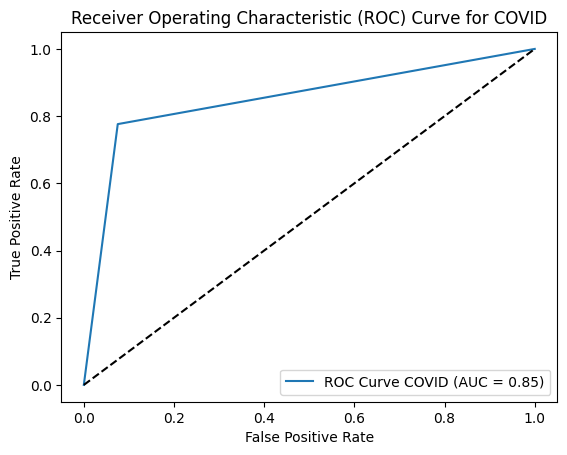

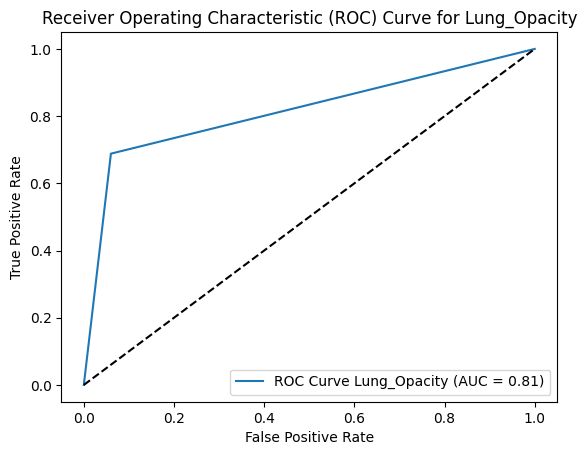

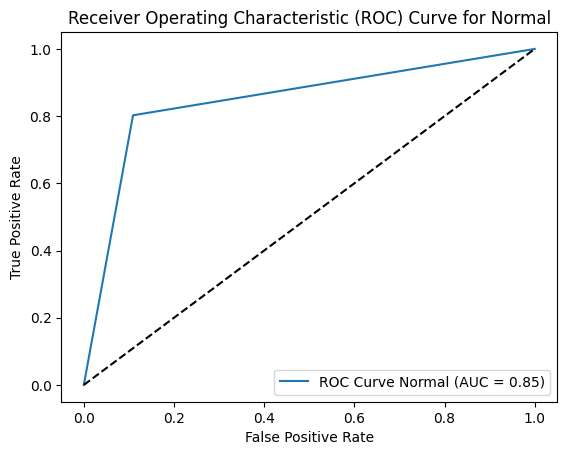

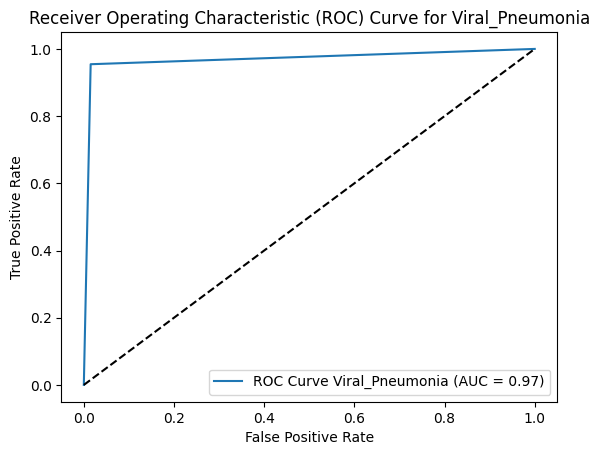

In [20]:
"""
-- Test the CNN model with raw images --

This cell traing the model previously trained with the test dataset.
It gets the predictiosn and then compares the results using metrics
like accuracy, precission, recall, f1 and roc/auc.
"""

predictions = model_cnn.predict(X_test_normal)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test_normal, axis=1)

# get the metrics
print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    covid_true.append(real_values[i] == 0)
    lung_op_true.append(real_values[i] == 1)
    normal_true.append(real_values[i] == 2)
    viral_pneu_true.append(real_values[i] == 3)

    # predictions
    covid_pred.append(predictions[i] == 0)
    lung_op_pred.append(predictions[i] == 1)
    normal_pred.append(predictions[i] == 2)
    viral_pneu_pred.append(predictions[i] == 3)

test_label_mat.append(covid_true)
test_label_mat.append(lung_op_true)
test_label_mat.append(normal_true)
test_label_mat.append(viral_pneu_true)

predictions_mat.append(covid_pred)
predictions_mat.append(lung_op_pred)
predictions_mat.append(normal_pred)
predictions_mat.append(viral_pneu_pred)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)

categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}

for category, value in categories.items():

    fpr, tpr, thresholds = roc_curve(test_label_mat[value], predictions_mat[value])

    auc = roc_auc_score(test_label_mat[value], predictions_mat[value])

    plt.plot(fpr, tpr, label=f'ROC Curve {category} (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing the random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {category}')
    plt.legend(loc='lower right')
    plt.show()

## Visualización de Mapas de Calor